Réplica del notebook https://github.com/juanmvsa/Sentiment-Analysis-TripAdvisor-Spanish/blob/main/3.1%20Fine-tuned%20Bert%20approach.ipynb

#Librerias

In [ ]:
pip install transformers

     |████████████████████████████████| 4.0 MB 8.5 MB/s 
     |████████████████████████████████| 596 kB 45.7 MB/s 
     |████████████████████████████████| 880 kB 60.2 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 6.6 MB 26.6 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=9e5a914a53682082be878a0447e062415d5c4049502825cf76adf75266447178
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import transformers
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import seaborn as sns
import re
import string
from collections import Counter, defaultdict
import string
#import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import re 
import torch
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error

#Opinion-Polaridad Analysis


 **Visualización de los datos**

In [ ]:
ls

Data_test/     __MACOSX/     train_data.csv
Data_test.zip  sample_data/  train_data.zip


In [ ]:
import torch
import tensorflow as tf

if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
train_data = pd.read_csv(r"./train_data.csv", sep=',',encoding='latin1', engine ="python" )

In [ ]:
# Function for removing quotes in the reviews
def remove_quotes(dataframe):
    nw = []
    for op in dataframe['Opinion']:
        nw.append(op.strip('"'))
    dataframe['Opinion'] = nw


In [ ]:
#Borramos los datos que no tienen opinion
train_data = train_data.drop(index=[8054,29566])


In [ ]:
remove_quotes(train_data)
TRAIN = train_data

In [ ]:
#Opinion-Atraction train dataset
opinion_attaction_data = train_data.drop(columns=['Title','Polarity'])
#Opinion-Polarity train Dataset
train_data=train_data.drop(columns=['Title','Attraction'])


In [ ]:
#Columnas
print("Train Data keys: ",train_data.keys())
print('\nDataset:\n',train_data.head())

Train Data keys:  Index(['Opinion', 'Polarity'], dtype='object')

Dataset:
                                              Opinion  Polarity
0  Piensen dos veces antes de ir a este hotel, te...         1
1  Cuatro de nosotros fuimos recientemente a Eddi...         1
2  seguiré corta y simple: limpieza\n- bad. Tengo...         1
3  Al reservar un hotel con multipropiedad Mayan ...         1
4  No pierdan su tiempo ni dinero, venimos porque...         1


In [ ]:
#Cambiando clases
# Set the classes from 0 - 4 (needed for BERT)
train_data['Polarity'] = train_data['Polarity'].replace([1,2,3,4,5], [0,1,2,3,4])


Para fines de evaluacion particionamos los datasets en train/test

In [ ]:
# Split the dataset into train and dev sets (90% - 10%)
from sklearn.model_selection import train_test_split
          
X_train, X_dev, y_train, y_dev = train_test_split(train_data['Opinion'], 
                                                    train_data['Polarity'],
                                                    test_size=0.80, 
                                                    random_state=1)

In [ ]:
_, X_dev, _, y_dev = train_test_split(X_dev, 
                                                    y_dev,
                                                    test_size=0.20, 
                                                    random_state=1)

In [ ]:
import numpy as np
# Check the classes
label_list = np.unique(y_train.values)
print(label_list)

[0 1 2 3 4]


In [ ]:
# Check the size of the sets
print('Size of the train set:', X_train.size, y_train.size)
print('Size of the dev set:', X_dev.size, y_dev.size)

Size of the train set: 6042 6042
Size of the dev set: 4834 4834


#Opinion Polarity

In [ ]:
# Save the reviews in variables for later use
opiniones = X_train.values
puntajes = y_train.values

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig

# Create the tokenizer and the model (BETO in this case)
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", do_lower_case=False)

model = BertForSequenceClassification.from_pretrained(
    "dccuchile/bert-base-spanish-wwm-cased", 
    num_labels = 5, # The number of output labels
    output_attentions = False, # Whether the model returns attentions weights
    output_hidden_states = True, # Whether the model returns all hidden-states
)

# Tell pytorch to run this model on the GPU.
#Concatenate each opinion sentiment 
#model = torch.cat((model, sentiment), 0) 
model.cuda()

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/364 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs
input_ids = []
attention_masks = []

for opinion in opiniones:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        opinion,                   #Sentence to encode.
                        add_special_tokens = True, #Add '[CLS]' and '[SEP]'
                        max_length = 400,           #Pad & truncate all sentences.
                        truncation = True,
                        padding='max_length',
                        return_attention_mask = True,  #Construct attn. masks.
                        return_tensors = 'pt',     #Return pytorch tensors.
                        verbose = True #Print more information and warnings.
                   )
    
    #Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    #And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

#Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(puntajes)

#Print sentence 0, now as a list of IDs.
print('Original: ', opiniones[0])
print('Token IDs:', input_ids[0])

Original:  Yo participe en varias actividades, el jogging en la playa estuvo muy padre, me divertí mucho. el animador Alberto super buena onda me enamoró??????. Edgar encargado :P fue un paseo padrisimo Gerardo Martínez el toallero también super buena onda. También vimos un montón de tortugas bebé y aprendimos a pescar jaja super divertido, lo recomiendo mucho
Token IDs: tensor([    4,  1584, 29278,  1036,  3748,  2360,  1017,  1040,  2736, 18241,
         1838,  1036,  1030,  7899,  4200,  1456,  2210,  1017,  1129,  3074,
         5069,  1789,  1009,  1040, 26843, 30936, 12374,  1843,  2667, 14662,
         1129,  6256, 30953,  1064,  1064,  1064,  1064,  1064,  1064,  1009,
        21379,  7916,  1181,  1068,  1341,  1049,  9906, 15220,  2652,  2645,
         6888,  6228, 12683,  1040,  1166, 28133,  1050,  1447,  1843,  2667,
        14662,  1009,  2497, 13855,  1049,  7182,  1008, 30706,  4871,  1042,
         7496,  1305,  1013, 19219,  5952,  1462,  1843,  6540,  1017,  1114,
  

In [ ]:
print(labels.size())
print(attention_masks.shape)
print(input_ids.size())
print(labels.shape)

torch.Size([6042])
torch.Size([6042, 400])
torch.Size([6042, 400])
torch.Size([6042])


In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split

# Calculate the number of samples to include in each set
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

5,437 training samples
  605 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#The DataLoader needs to know our batch size for training, so we specify it 
#here. For fine-tuning BERT on a specific task, the authors recommend a batch 
#size of 8, 16, 32, 64, or 128
batch_size = 16

#Create the DataLoaders for our training and validation sets.
#We'll take training samples in random order
train_dataloader = DataLoader(
            train_dataset,  #The training samples.
            sampler = RandomSampler(train_dataset), #Select batches randomly
            batch_size = batch_size #Trains with this batch size
        )

#For validation the order doesn't matter, so we'll just read them sequentially
validation_dataloader = DataLoader(
            val_dataset, # The validation samples
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially
            batch_size = batch_size # Evaluate with this batch size
        )

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-6, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                )

from transformers import get_linear_schedule_with_warmup

epochs = 2 #The BERT authors recommend 4 epochs

# Total number of training steps is [number of batches] x [number of epochs]
# (Note that this is not the same as the number of training samples)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value
                                            num_training_steps = total_steps)

#Calculates the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs"
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0
        # This is to help prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Training epcoh took: {:}".format(training_time))
        
    #               Validation


    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training)
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took
    validation_time = format_time(time.time() - t0)
    
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,

            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    680.    Elapsed: 0:00:22.
  Batch    80  of    680.    Elapsed: 0:00:45.
  Batch   120  of    680.    Elapsed: 0:01:08.
  Batch   160  of    680.    Elapsed: 0:01:31.
  Batch   200  of    680.    Elapsed: 0:01:55.
  Batch   240  of    680.    Elapsed: 0:02:19.
  Batch   280  of    680.    Elapsed: 0:02:43.
  Batch   320  of    680.    Elapsed: 0:03:07.
  Batch   360  of    680.    Elapsed: 0:03:32.
  Batch   400  of    680.    Elapsed: 0:03:57.
  Batch   440  of    680.    Elapsed: 0:04:21.
  Batch   480  of    680.    Elapsed: 0:04:46.
  Batch   520  of    680.    Elapsed: 0:05:11.
  Batch   560  of    680.    Elapsed: 0:05:36.
  Batch   600  of    680.    Elapsed: 0:06:01.
  Batch   640  of    680.    Elapsed: 0:06:26.

  Training epcoh took: 0:06:51

Running Validation...
  Accuracy: 0.74
  Validation took: 0:00:18

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    680.    Elapsed: 0:00:25.
  Batch    80  o

Test

In [ ]:
#Test 
df_test = pd.concat([X_dev, y_dev], axis=1)

# Remove the quotes in the reviews 
remove_quotes(df_test)

In [ ]:
# Report the number of sentences
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

# Create sentence and label lists
opiniones = df_test['Opinion'].values
#puntajes = y_dev.values

# Tokenize all of the sentences and map the tokens to thier word IDs
input_ids = []
attention_masks = []

for opinion in opiniones:
    encoded_dict = tokenizer.encode_plus(
                        opinion,                      # Sentence to encode
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                        truncation=True
                   )
    
    # Add the encoded sentence to the list  
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding)
    attention_masks.append(encoded_dict['attention_mask'])

#Convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

#Set the batch size
batch_size = 32  

#Create the DataLoader
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 6,042



In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch
    
    with torch.no_grad():
        result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, return_dict=True)
        logits = result.logits
        logits = logits.detach().cpu().numpy()
    
        predictions.append(logits)

print('    DONE.')

Predicting labels for 6,042 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np
# Combine the results across all batches
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

NameError: ignored

In [ ]:
# Set the classes in a range between 0 - 4
df1 = pd.DataFrame(flat_predictions, columns=['Polarity'])
df1['Polarity'] = df1['Polarity'].replace([0,1,2,3,4], [1,2,3,4,5])
df_test['Polarity'] = df_test['Polarity'].replace([0,1,2,3,4], [1,2,3,4,5])

In [ ]:
np.unique(df_test['Polarity'])

array([1, 2, 3, 4, 5])

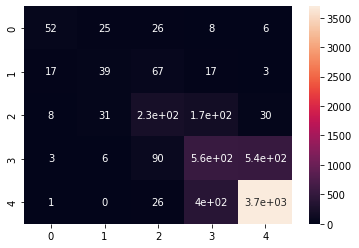

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

confusion_matri = confusion_matrix(df_test['Polarity'], df1['Polarity'])
sn.heatmap(confusion_matri, annot=True)
plt.show()

In [ ]:
confusion_matri

array([[  52,   25,   26,    8,    6],
       [  17,   39,   67,   17,    3],
       [   8,   31,  227,  174,   30],
       [   3,    6,   90,  556,  537],
       [   1,    0,   26,  400, 3693]])

In [ ]:
#Test: df_test
#Pred: df1
def table_wrong_preds( X, y_real, y_pred):
  w_opinion = []
  real = []
  w_pred = []
  for i in range(len(X)):
    if list(y_real)[i] != list(y_pred)[i]:
      w_opinion.append( list(X)[i])
      real.append( list(y_real)[i] )
      w_pred.append(list(y_pred)[i])

  #Tabla de predicciones erroneas
  wrong_pred = pd.DataFrame()
  wrong_pred['Opinion'] = w_opinion
  wrong_pred['Real'] = real
  wrong_pred['Prediccion'] = w_pred
  return wrong_pred
wrong_pred = table_wrong_preds(X =df_test['Opinion'] ,y_real = df_test['Polarity'] , y_pred = df1['Polarity'])
wrong_pred.head()
#np.savetxt('wrong_train_results.txt', wrong_pred, delimiter=',') 


In [ ]:
len(wrong_pred)

1475

In [ ]:
len(df_test)

6042

In [ ]:
#wrong_pred.to_csv(r'c:\content\wrong_train_results.txt', header=None, index=None, sep='\t', mode='a')
#np.savetxt('wrong_train_results.txt', wrong_pred.to_numpy(), fmt = "%d") 

In [ ]:
med_bad_preds = []
for i in range(len(wrong_pred)):
  if (wrong_pred['Prediccion'][i] == 1 and wrong_pred['Real'][i] == 4) or (wrong_pred['Prediccion'][i] == 4 and wrong_pred['Real'][i] == 1) or (wrong_pred['Prediccion'][i] == 5 and wrong_pred['Real'][i] == 2) or (wrong_pred['Prediccion'][i] == 2 and wrong_pred['Real'][i] == 5):
    med_bad_preds.append(i)
med_bad_preds_df = wrong_pred.iloc[med_bad_preds]
print("Malas predicciones (dif. de 3):", len(med_bad_preds_df), '\n', med_bad_preds_df)

bad_preds = []
for i in range(len(wrong_pred)):
  if (wrong_pred['Prediccion'][i] == 1 and wrong_pred['Real'][i] == 5) or (wrong_pred['Prediccion'][i] == 5 and wrong_pred['Real'][i] == 1):
    bad_preds.append(i)
bad_preds_df = wrong_pred.iloc[bad_preds]
print("Muy malas predicciones (dif. de 4):", len(bad_preds_df), '\n', bad_preds_df)

Malas predicciones (dif. de 3): 14 
                                                 Opinion  Real  Prediccion
41    Las momias se formaron por un proceso natural ...     1           4
140   Viajamos a la Marina en noviembre de 2015. May...     1           4
415   La propiedad es hermosa, con amplias suites. E...     1           4
532   Visité junto con mi esposa Mayan en nuevo Vall...     4           1
539   Pues llegamos de vacaciones a este hotel y ten...     4           1
577   No me malinterpretes, el edificio es absolutam...     1           4
621   Buen Lugar, excelente comida y bebidas, todo e...     2           5
782   No tenemos ninguna intención de asistir. Miemb...     1           4
791   No beber las margaritas. deben utilizar racill...     1           4
1075  Durante mi estadía, la llave de mi habitación ...     4           1
1420  El restaurante/bar no decirles que puedes cons...     2           5
1441  La comida era buena, el servicio era excelente...     1           4
1

In [ ]:
classes = []
for i in df1['Polarity']:
    classes.append(str(i))

indexes = []
for i in range(len(flat_predictions)):
    indexes.append(str(i))

Mean absolute error

In [ ]:
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(df_test['Polarity'], df1['Polarity'])
print(MAE)

0.2709367759020192


#Test set


In [ ]:
# Load the prediction dataset
test_data = pd.read_csv(r"/content/Data_test/Test_data.csv", sep=',',encoding='latin1', engine ="python" )
print("Test Data keys: ",test_data.keys())
#Test
test = test_data.drop(columns=['Title'])
# Remove the quotes in the reviews 
remove_quotes(test)

Test Data keys:  Index(['Id', 'Title', 'Opinion'], dtype='object')


In [ ]:
# Report the number of sentences
print('Number of test sentences: {:,}\n'.format(test.shape[0]))

# Create sentence and label lists
opiniones = test['Opinion'].values
#puntajes = y_dev.values

# Tokenize all of the sentences and map the tokens to thier word IDs
input_ids = []
attention_masks = []

for opinion in opiniones:
    encoded_dict = tokenizer.encode_plus(
                        opinion,                      # Sentence to encode
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                        truncation=True
                   )
    
    # Add the encoded sentence to the list  
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding)
    attention_masks.append(encoded_dict['attention_mask'])

#Convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

#Set the batch size
batch_size = 32  

#Create the DataLoader
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 12,938



In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch
    
    with torch.no_grad():
        result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, return_dict=True)
        logits = result.logits
        logits = logits.detach().cpu().numpy()
    
        predictions.append(logits)

print('    DONE.')

Predicting labels for 12,938 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import mean_absolute_error
# Combine the results across all batches
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
# Set the classes in a range between 0 - 4
df1 = pd.DataFrame(flat_predictions, columns=['Polarity'])
df1['Polarity'] = df1['Polarity'].replace([0,1,2,3,4], [1,2,3,4,5])
df1.to_csv(r'pred_opinion_polarity.txt', header=None, index=None, sep='\t', mode='a')



#Opinion-Attraction

In [ ]:
opinion_attaction_data.head()

,Opinion,Attraction
0,"Piensen dos veces antes de ir a este hotel, te...",Hotel
1,Cuatro de nosotros fuimos recientemente a Eddi...,Restaurant
2,seguiré corta y simple: limpieza\n- bad. Tengo...,Hotel
3,Al reservar un hotel con multipropiedad Mayan ...,Hotel
4,"No pierdan su tiempo ni dinero, venimos porque...",Hotel


In [ ]:
opinion_attaction_data2 = opinion_attaction_data.copy()
opinion_attaction_data2 = opinion_attaction_data2['Attraction'].replace('Hotel',0).to_frame()
opinion_attaction_data2 = opinion_attaction_data2['Attraction'].replace('Restaurant',1).to_frame()
opinion_attaction_data2 = opinion_attaction_data2['Attraction'].replace('Attractive',2).to_frame()

In [ ]:
opinion_attaction_data = pd.concat([opinion_attaction_data, opinion_attaction_data2], axis=1)
opinion_attaction_data.columns = ['Opinion', 'Attraction', 'Label']

In [ ]:
opinion_attaction_data.head()

,Opinion,Attraction,Label
0,"Piensen dos veces antes de ir a este hotel, te...",Hotel,0
1,Cuatro de nosotros fuimos recientemente a Eddi...,Restaurant,1
2,seguiré corta y simple: limpieza\n- bad. Tengo...,Hotel,0
3,Al reservar un hotel con multipropiedad Mayan ...,Hotel,0
4,"No pierdan su tiempo ni dinero, venimos porque...",Hotel,0


Datos de entrenamiento:

In [ ]:
train_data2 = opinion_attaction_data.drop(columns=['Attraction'])
train_data2.head()

,Opinion,Label
0,"Piensen dos veces antes de ir a este hotel, te...",0
1,Cuatro de nosotros fuimos recientemente a Eddi...,1
2,seguiré corta y simple: limpieza\n- bad. Tengo...,0
3,Al reservar un hotel con multipropiedad Mayan ...,0
4,"No pierdan su tiempo ni dinero, venimos porque...",0


Para fines de evaluacion particionamos los datasets en train/test

In [ ]:
# Split the dataset into train and dev sets (80% - 20%)
from sklearn.model_selection import train_test_split
          
X_train, X_dev, y_train, y_dev = train_test_split(train_data2['Opinion'], 
                                                    train_data2['Label'],
                                                    test_size=0.2, 
                                                    random_state=1)

In [ ]:
import numpy as np
# Check the classes
label_list = np.unique(y_train.values)
print(label_list)

[0 1 2]


In [ ]:
# Check the size of the sets
print('Size of the train set:', X_train.size, y_train.size)
print('Size of the dev set:', X_dev.size, y_dev.size)

Size of the train set: 24168 24168
Size of the dev set: 6042 6042


In [ ]:
# Save the reviews in variables for later use
opiniones = X_train.values
puntajes = y_train.values

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig

# Create the tokenizer and the model (BETO in this case)
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", do_lower_case=False)

model = BertForSequenceClassification.from_pretrained(
    "dccuchile/bert-base-spanish-wwm-cased", 
    num_labels = 3, # The number of output labels
    output_attentions = False, # Whether the model returns attentions weights
    output_hidden_states = True, # Whether the model returns all hidden-states
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs
input_ids = []
attention_masks = []

for opinion in opiniones:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        opinion,                   #Sentence to encode.
                        add_special_tokens = True, #Add '[CLS]' and '[SEP]'
                        max_length = 512,           #Pad & truncate all sentences.
                        truncation = True,
                        padding='max_length',
                        return_attention_mask = True,  #Construct attn. masks.
                        return_tensors = 'pt',     #Return pytorch tensors.
                        verbose = True #Print more information and warnings.
                   )
    
    #Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    #And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

#Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(puntajes)

#Print sentence 0, now as a list of IDs.
print('Original: ', opiniones[0])
print('Token IDs:', input_ids[0])

Original:  Acabo de volver de Nayarit, el complejo está
muy bien cuidado y muy limpio.
Muchas actividades para los niños, día y noche. Impresionante Teen
Club y entretenimiento agradable, no queso, luz para los adultos también.
La comida es buena, nada espectacular, pero es
agradable cuando en vacaciones.
Volveremos!!!
Token IDs: tensor([    4,  9256,  1008,  2649,  1008,  2728, 22212,  1202,  1017,  1040,
         9363,  1266,  1456,  1311,  4499,  1042,  1456, 10717,  1009,  5794,
         2360,  1110,  1065,  2330,  1017,  1726,  1042,  2109,  1009, 30437,
         1484,  1014,  6417,  1042, 19155,  7789,  1017,  1084, 11769,  1017,
         3527,  1110,  1065,  8033,  1447,  1009,  1198,  4470,  1058,  2667,
         1017,  1671, 19072,  1017,  1355,  1058,  7789,  1486,  1036,  6507,
         1009, 28866,  1127,  1127,  1127,     5,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,  

In [ ]:
labels.size()

torch.Size([24168])

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split

# Calculate the number of samples to include in each set
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

21,751 training samples
2,417 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#The DataLoader needs to know our batch size for training, so we specify it 
#here. For fine-tuning BERT on a specific task, the authors recommend a batch 
#size of 8, 16, 32, 64, or 128
batch_size = 8

#Create the DataLoaders for our training and validation sets.
#We'll take training samples in random order
train_dataloader = DataLoader(
            train_dataset,  #The training samples.
            sampler = RandomSampler(train_dataset), #Select batches randomly
            batch_size = batch_size #Trains with this batch size
        )

#For validation the order doesn't matter, so we'll just read them sequentially
validation_dataloader = DataLoader(
            val_dataset, # The validation samples
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially
            batch_size = batch_size # Evaluate with this batch size
        )

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                )

from transformers import get_linear_schedule_with_warmup

epochs = 1 #The BERT authors recommend 4 epochs

# Total number of training steps is [number of batches] x [number of epochs]
# (Note that this is not the same as the number of training samples)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value
                                            num_training_steps = total_steps)

#Calculates the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs"
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0
        # This is to help prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Training epcoh took: {:}".format(training_time))
        
    #               Validation


    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training)
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took
    validation_time = format_time(time.time() - t0)
    
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,

            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 1 ========
Training...
  Batch    40  of  2,719.    Elapsed: 0:00:29.
  Batch    80  of  2,719.    Elapsed: 0:00:58.
  Batch   120  of  2,719.    Elapsed: 0:01:28.
  Batch   160  of  2,719.    Elapsed: 0:01:58.
  Batch   200  of  2,719.    Elapsed: 0:02:29.
  Batch   240  of  2,719.    Elapsed: 0:03:00.
  Batch   280  of  2,719.    Elapsed: 0:03:31.
  Batch   320  of  2,719.    Elapsed: 0:04:02.
  Batch   360  of  2,719.    Elapsed: 0:04:34.
  Batch   400  of  2,719.    Elapsed: 0:05:06.
  Batch   440  of  2,719.    Elapsed: 0:05:38.
  Batch   480  of  2,719.    Elapsed: 0:06:09.
  Batch   520  of  2,719.    Elapsed: 0:06:41.
  Batch   560  of  2,719.    Elapsed: 0:07:13.
  Batch   600  of  2,719.    Elapsed: 0:07:45.
  Batch   640  of  2,719.    Elapsed: 0:08:17.
  Batch   680  of  2,719.    Elapsed: 0:08:49.
  Batch   720  of  2,719.    Elapsed: 0:09:21.
  Batch   760  of  2,719.    Elapsed: 0:09:53.
  Batch   800  of  2,719.    Elapsed: 0:10:25.
  Batch   840  of

Test

In [ ]:
#Test 
df_test = pd.concat([X_dev, y_dev], axis=1)

# Remove the quotes in the reviews 
remove_quotes(df_test)

In [ ]:
# Report the number of sentences
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

# Create sentence and label lists
opiniones = df_test['Opinion'].values
#puntajes = y_dev.values

# Tokenize all of the sentences and map the tokens to thier word IDs
input_ids = []
attention_masks = []

for opinion in opiniones:
    encoded_dict = tokenizer.encode_plus(
                        opinion,                      # Sentence to encode
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                        truncation=True
                   )
    
    # Add the encoded sentence to the list  
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding)
    attention_masks.append(encoded_dict['attention_mask'])

#Convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

#Set the batch size
batch_size = 32  

#Create the DataLoader
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 6,042



In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch
    
    with torch.no_grad():
        result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, return_dict=True)
        logits = result.logits
        logits = logits.detach().cpu().numpy()
    
        predictions.append(logits)

print('    DONE.')

Predicting labels for 6,042 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import mean_absolute_error
# Combine the results across all batches
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
# Dataframe of predictions
df2 = pd.DataFrame(flat_predictions, columns=['Attraction'])

In [ ]:
print(np.unique(df_test['Label']))
print(np.unique(df2['Attraction']))

[0 1 2]
[0 1 2]


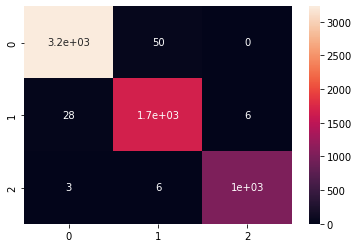

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

confusion_matri = confusion_matrix(df_test['Label'], df2['Attraction'])
sn.heatmap(confusion_matri, annot=True)
plt.show()

In [ ]:
confusion_matri

array([[3229,   50,    0],
       [  28, 1687,    6],
       [   3,    6, 1033]])

In [ ]:
len(df_test['Opinion'])

6042

In [ ]:
#Test: df_test
#Pred: df2
wrong_pred = table_wrong_preds(X = df_test['Opinion'] ,y_real = df_test['Label'] , y_pred = df2['Attraction'])
wrong_pred.head()
#np.savetxt('wrong_train_results.txt', wrong_pred, delimiter=',') 


,Opinion,Real,Prediccion
0,"Dentro de los restaurantes: Market, buffet, no...",0,1
1,Este jardín resultó una excelente opción para ...,2,1
2,"Muy buenos los desayunos comidas y cenas, igua...",0,1
3,"Personal de recepción amable. Gran vista, sele...",1,0
4,Excelente servicio y buenas bebidas y comida. ...,0,1


In [ ]:
len(wrong_pred)

93

In [ ]:
len(df_test)

6042

In [ ]:
wrong_pred.to_csv(r'wrong_train_results2.txt', header=None, index=None, sep='\t', mode='a')
#np.savetxt('wrong_train_results.txt', wrong_pred.to_numpy(), fmt = "%d") 

Test Data

In [ ]:
# Report the number of sentences
print('Number of test sentences: {:,}\n'.format(test.shape[0]))

# Create sentence and label lists
opiniones = test['Opinion'].values
#puntajes = y_dev.values

# Tokenize all of the sentences and map the tokens to thier word IDs
input_ids = []
attention_masks = []

for opinion in opiniones:
    encoded_dict = tokenizer.encode_plus(
                        opinion,                      # Sentence to encode
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                        truncation=True
                   )
    
    # Add the encoded sentence to the list  
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding)
    attention_masks.append(encoded_dict['attention_mask'])

#Convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

#Set the batch size
batch_size = 32  

#Create the DataLoader
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 12,938



In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch
    
    with torch.no_grad():
        result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, return_dict=True)
        logits = result.logits
        logits = logits.detach().cpu().numpy()
    
        predictions.append(logits)

print('    DONE.')

Predicting labels for 12,938 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import mean_absolute_error
# Combine the results across all batches
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
# Set the classes in a range between 0 - 4
df3 = pd.DataFrame(flat_predictions, columns=['Attraction'])
df3.to_csv(r'pred_opinion_attraction.txt', header=None, index=None, sep='\t', mode='a')



Error

In [ ]:
from sklearn.metrics import f1_score
y_true = df_test['Label'] 
y_pred = df2['Attraction']
F1_macro = f1_score(y_true, y_pred, average='macro')
print(F1_macro)

0.9848077291794185


In [ ]:
Sentiment_result = (1/(1+MAE))+ F1_macro
Sentiment_result = Sentiment_result/2

Result:  0.8858144649282951 (Rest-Mex Metric)

In [ ]:
print("Result: ", Sentiment_result)

Result:  0.8858144649282951


#Final Results Presentation

In [ ]:
!gdown --i '1n797eK0R6aB_T7Ie9PDRN3Ryj3CrQaV0'
!unzip '/content/results_bert.zip'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1n797eK0R6aB_T7Ie9PDRN3Ryj3CrQaV0
To: /content/results_bert.zip
100% 960k/960k [00:00<00:00, 157MB/s]
Archive:  /content/results_bert.zip
  inflating: pred_opinion_attraction.txt  
  inflating: __MACOSX/._pred_opinion_attraction.txt  
  inflating: wrong_train_results2.txt  
  inflating: __MACOSX/._wrong_train_results2.txt  
  inflating: pred_opinion_polarity.txt  
  inflating: __MACOSX/._pred_opinion_polarity.txt  
  inflating: c__content_wrong_train_results.txt  
  inflating: __MACOSX/._c__content_wrong_train_results.txt  


In [ ]:
ls

c__content_wrong_train_results.txt  results_bert.zip
__MACOSX/                           sample_data/
pred_opinion_attraction.txt         wrong_train_results2.txt
pred_opinion_polarity.txt


In [ ]:
import pandas as pd
import numpy as np
pred1 = pd.read_table("pred_opinion_polarity.txt", delimiter=" ", header = None)
pred2 = pd.read_table("pred_opinion_attraction.txt", delimiter=" ", header = None)

In [ ]:
pred2 = pred2.replace([0,1,2],['Hotel','Restaurant','Attractive'])
number = []
for i in range(len(pred2)):
  number.append(i+1)
print(number)
number = pd.DataFrame(number, columns=['NumberofOpinion'])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [ ]:
taskname = pd.DataFrame(np.zeros((len(pred1), 1)))
taskname.columns = ['TaskName']
taskname = taskname.replace([0],['sentiment'])
print(len(list(taskname)))
print(len(list(number)))
print(len(list(pred1)))
print(len(list(pred2)))
taskname.head()

1
1
1
1


,TaskName
0,sentiment
1,sentiment
2,sentiment
3,sentiment
4,sentiment


In [ ]:
final_data = pd.concat([taskname, number, pred1, pred2], axis=1)
final_data.columns = ['TaskName', 'NumberofOpinion', 'Polarity', 'Attraction']
final_data.head()

,TaskName,NumberofOpinion,Polarity,Attraction
0,sentiment,1,5,Hotel
1,sentiment,2,4,Restaurant
2,sentiment,3,5,Hotel
3,sentiment,4,4,Attractive
4,sentiment,5,5,Attractive


In [ ]:
print(len(final_data))

12938


In [ ]:
final_data.to_csv(r'Bert_final_ERIKA_CIPRI.txt', header=None, index=None, sep='\t', line_terminator ='\n', mode='a')